# Modeling , Param Tuning, Evulating, Explaining & Prediction

In [57]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle 
import warnings
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss,roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
import shap
import json
import imblearn

import DATA_PROCESSING as process
%pylab inline
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['identity', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy


# Running parameters

In [58]:
SAMPLE = 2000 # minimum 2000
USE_SMOTE = True
CALC_PARAMS = True
dev_mode = False
config_file = "configuration_01_15_2022__08_18_sample_1000000.csv"


In [59]:
columns_cum =['app_cat','manufacturer','device_model','device_version','user_isp']
columns_dummies=['banner_pos', 'Day_of_Week','state','manufacturer','Month','hour','user_isp','app_cat','device_model','device_version']
features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'device_height', 'device_width', 'device_diag', 'Day_of_Week', 'Month', 'hour']
cat_features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'Day_of_Week', 'Month', 'hour']

# Read Training Data

In [60]:
df = pd.read_pickle("train_set.pickle").sample(n=SAMPLE)
df.loc[:,"clicked"] = df.loc[:,"clicked"].map({True:1, False:0})

### Imputing, Feature engineering,Cardinality reductions , and dummy coding 

In [61]:
def preprocessing_pipeline(df, one_hot_encoding=True, allowed_levels_dict = None):
    df= df.drop(['op_id', 'resolution','app_id'], axis=1)
    # if  a dict of categorical columns and theyr allowed levels is given - replace levels not in the list as "<col_name>_other"
    if allowed_levels_dict:
        for col_name, categories_list in allowed_levels_dict.items():
            df.loc[:, col_name] = df[col_name].map(lambda x: x if x in categories_list else f"{col_name}_other")
    df=process.Missing_values(df)
    df=process.Feature_engineering(df)
    if not allowed_levels_dict:
        df, cat_dict = process.cumulatively_categorise(df,columns_cum)
    if one_hot_encoding:
        df=process.get_dummies_fun(df,columns_dummies)
    return df,allowed_levels_dict if allowed_levels_dict else cat_dict 

In [62]:
print (datetime.datetime.now())
df, allowed_levels_dict = preprocessing_pipeline(df, one_hot_encoding=USE_SMOTE)
MODEL_COLS = list(df.columns)
df.shape
print (datetime.datetime.now())


2022-01-16 22:15:51.060475
summary of missing values before imputing missing data: 
manufacturer    591
device_model    591
dtype: int64
summary of missing values after imputing missing data based on device version
manufacturer    46
device_model    46
dtype: int64
summary of missing values after imputing missing data by assigning a separate category
Series([], dtype: int64)
2022-01-16 22:15:53.000586


# exploring the Target Encoder

for classification tasks Target encoding is a novel and usefull method for converting high-cardinality categorical variable to a continuous value by encoding for each level the propoprion of rows in which Y=1\
i.e. for click prediction it encodes the ctr for each level over the entire dataset



encoder = ce.TargetEncoder(cols=cat_features)
encoded = encoder.fit_transform(df[features], df['clicked'])
encoded.describe()

# look at Class (Im)Balance

In [63]:
df.groupby('clicked').clicked.count()

clicked
0    1858
1     142
Name: clicked, dtype: int64

# splitting the data test to 3 parts:
1. training: 80%
2. validation: 10% - for param tunning 
3. test set: 10% a final test set to evaluate the perfromance of the final model, only after all tunning has completed.

In [64]:
train_df, other = train_test_split(df, test_size=0.2, random_state=42)
dev_val, dev_test = train_test_split(other, test_size=0.5, random_state=42)


In [65]:
train_df.shape, dev_val.shape,  dev_test.shape

((1600, 226), (200, 226), (200, 226))

# SMOTE oversampling - on the training set only

In [66]:
def appply_smote(df):
    cat_features =  [c for c in df.columns if 'device_' not in c and c != 'clicked']
    features =  [c for c in df.columns if c != 'clicked']
    
    kw_args={
                'y':df['clicked'],
                'X_cols' :list(df[features].columns),
                'y_cols' :list(df[['clicked']].columns)
            }
    smote_transformer = FunctionTransformer(process.Smote_alg,kw_args=kw_args,validate=True)

    smote_pipe = Pipeline([('smote', smote_transformer)])
    new_df, new_y = smote_pipe.fit_transform(df[features])

    #print ('Before', df[features].shape, df['clicked'].shape, 'After', new_df.shape, new_y.shape)
    
    new_df.loc[:, 'clicked'] = new_y['clicked']
    df = new_df[MODEL_COLS]
    cat_features = []
    return df, features, cat_features



In [67]:
#TODO add the explanation here
print (datetime.datetime.now())
if USE_SMOTE:
    train_df, features, cat_features = appply_smote(train_df)
print (datetime.datetime.now())


2022-01-16 22:15:53.370608
org X.shape (1600, 225) len(X_cols) 225
new_X.shape (2966, 225)
2022-01-16 22:15:53.469613


In [68]:
# another look at class imbalance
if USE_SMOTE:
    print (train_df.groupby('clicked').clicked.count())

clicked
0    1483
1    1483
Name: clicked, dtype: int64


In [69]:
dev_val.head()

,device_height,device_width,clicked,device_diag,bottom,bottom-left,bottom-right,center,left,right,...,Z965,Z981,Z982,Z983,device_model_other,6.0.1,7.0,7.1.1,8.0.0,device_version_other
1198,720,1280,0,45.0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
720,480,854,0,26.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1381,720,1280,0,45.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
63,854,480,0,26.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
630,1280,800,0,40.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Columns: 226 entries, device_height to device_version_other
dtypes: float64(225), int64(1)
memory usage: 5.1 MB


In [71]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']
X_test = dev_test[features]
y_test = dev_test['clicked']


In [72]:
def get_config(model):
    d = configs.loc[model].params
    params = json.loads(d)
    print (params)
    return (params)

if not CALC_PARAMS:
    configs = pd.read_csv(config_file).set_index('index')
    print (configs)

# Preparing for pipeline creation

In [73]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [74]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [75]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [76]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_metric = float('-inf')
    worst_metric = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g, target_encoding = (USE_SMOTE == False))
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_hat, pos_label=1)
        curr_metric = auc(fpr, tpr)
        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best metric", best_metric, ", Grid:", best_grid)
    print ("worst metric", worst_metric, ", Grid:", best_grid)
    return best_grid

#### this function calculates final metrics on a tuned model, finds the optimal threshold for it

In [77]:
def evaulate_pipeline(pipe, X, y, params):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
   
    result = {
        "Accuracy": accuracy_score(y, y_pred, normalize=True),
        "Recall": recall_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "AUC": auc,
        "-LogLoss(higer is better)": -log_loss(y, y_pred),
        "threshold":   best_threshold,
        "params": json.dumps(params)
    }
    return result
    

# Model 1: Random Forest PipeLine

In [79]:
identity  = FunctionTransformer(lambda x:x, validate=True)

def make_rf_pipe_line(calibration = None, params = None , target_encoding = True):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features) if target_encoding else identity
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


### Parameters being tuned:
1. min_samples_leaf = the minimal number of observations in a new leaf that are required in order for creating it
2. max_depth        = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. class_weight     = the strategy for creating class weights to handle imbalanced data
4. n_estimators     = the totl number of trees in the forest
5. criterion        = the metric for calculating improvement in information by the node splitting: Gini inequality or entropy

In [80]:
# this is a long step, was executed and saved previously
print (datetime.datetime.now())

if CALC_PARAMS:

    if dev_mode:
        rf_params_grid ={'min_samples_leaf': [50, 100], 
                     'max_depth': [3,5] ,
                     'class_weight' : ['balanced'],
                     'n_estimators': [100],
                     'criterion': ["gini"]

                    }     
    else:    
        rf_params_grid ={'min_samples_leaf': [50, 100, 500], 
                         'max_depth': [3,5] ,
                         'class_weight' : [None] if USE_SMOTE else ['balanced', None]  ,
                         'n_estimators': [100, 200],
                         'criterion': ["gini"]

                        }
    best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)
else:
    get_config
    best_rf_params = get_config('RF')
print (datetime.datetime.now())


2022-01-16 22:15:54.742686
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 100}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 50, 'n_estimators': 200}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 100}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 200}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 500, 'n_estimators': 100}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 500, 'n_estimators': 200}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50, 'n_estimators': 100}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 50, 'n_estimators': 200}
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 100}
{'class_weight': None, 

In [81]:

rf_pipe = make_rf_pipe_line(calibration = 'sigmoid' if USE_SMOTE else None,
                            params = best_rf_params,
                            target_encoding = (USE_SMOTE==False))


Best Threshold: 0.8461550655719012 , with accuracy =  0.95


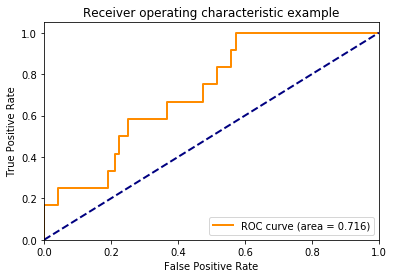

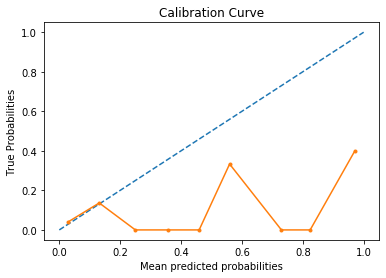

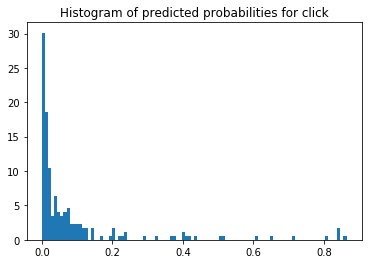

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.95,0.166667,1.0,0.715869,-1.726939,0.846155,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."


In [82]:
rf_results = evaulate_pipeline(rf_pipe, X_test, y_test, best_rf_params)
rf_df = pd.DataFrame(rf_results, index= ['RF'])
rf_df

# Model 2: CatBoost 

In [83]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)


In [84]:
def make_catboost_pipe_line(train_pool, validation_pool , class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features= cat_features ,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=validation_pool, plot=True)
    return model


### Parameters being tuned:
1. min_child_samples  = the minimal number of observations in a new leaf that are required in order for creating it
2. depth              = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. l2_leaf_reg        = L2 regularization coeffecient  
4. n_estimators       = the totl number of trees in the forest
5. subsample          = proprtion of rows sampled in each tree growin


In [85]:
if dev_mode:
    catboost_params_grid ={ 
                      'depth': [4,6,8] ,
                      'min_child_samples' : [100,500],
                      'n_estimators': [100],
                      'subsample': [0.95],
                      'l2_leaf_reg':[1],

                    }
else:     
    catboost_params_grid ={ 
                      'depth': [4,6,8] ,
                      'min_child_samples' : [100,500,1000],
                      'n_estimators': [100,200],
                      'subsample': [0.75,0.95],
                      'l2_leaf_reg':[1,2],

                    }


In [86]:
print (datetime.datetime.now())

model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
if CALC_PARAMS:

    search_results = model.randomized_search(catboost_params_grid,
                      train_pool,
                      y=None,
                      cv=3,
                      n_iter=10,
                      partition_random_seed=0,
                      calc_cv_statistics=True,
                      search_by_train_test_split=True,
                      refit=True,
                      shuffle=True,
                      stratified=None,
                      train_size=0.8,
                      verbose=False,
                      log_cout=sys.stdout,
                  log_cerr=sys.stderr)

    best_catboost_params = search_results['params']
    best_catboost_params

else:
    best_catboost_params = get_config('catboost')
print (datetime.datetime.now())


2022-01-16 22:16:06.424354
0:	learn: 0.6383755	test: 0.6361547	best: 0.6361547 (0)	total: 8.42ms	remaining: 1.68s
30:	learn: 0.3021987	test: 0.3073760	best: 0.3073760 (30)	total: 273ms	remaining: 1.49s
60:	learn: 0.2230022	test: 0.2309222	best: 0.2309222 (60)	total: 504ms	remaining: 1.15s
90:	learn: 0.1850839	test: 0.1957783	best: 0.1957783 (90)	total: 772ms	remaining: 925ms
120:	learn: 0.1639603	test: 0.1751642	best: 0.1751642 (120)	total: 1.03s	remaining: 671ms
150:	learn: 0.1476118	test: 0.1602494	best: 0.1602494 (150)	total: 1.25s	remaining: 404ms
180:	learn: 0.1369330	test: 0.1530227	best: 0.1530227 (180)	total: 1.47s	remaining: 154ms
199:	learn: 0.1301012	test: 0.1472410	best: 0.1472410 (199)	total: 1.68s	remaining: 0us

bestTest = 0.1472409572
bestIteration = 199

0:	learn: 0.6461381	test: 0.6437960	best: 0.6437960 (0)	total: 77.7ms	remaining: 15.5s
30:	learn: 0.2453696	test: 0.2570175	best: 0.2570175 (30)	total: 2.01s	remaining: 11s
60:	learn: 0.1643276	test: 0.1850178	best: 0.

### optimized configuration for catboost

In [87]:
best_catboost_params

{'min_data_in_leaf': 100,
 'depth': 8,
 'l2_leaf_reg': 2,
 'iterations': 200,
 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [88]:
catboost_pipe = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, params = best_catboost_params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6492047	test: 0.6497139	best: 0.6497139 (0)	total: 74.8ms	remaining: 14.9s
30:	learn: 0.2348789	test: 0.3391481	best: 0.3391481 (30)	total: 2.07s	remaining: 11.3s
60:	learn: 0.1594305	test: 0.2861034	best: 0.2861034 (60)	total: 4.02s	remaining: 9.17s
90:	learn: 0.1236628	test: 0.2613637	best: 0.2613637 (90)	total: 5.83s	remaining: 6.98s
120:	learn: 0.0994467	test: 0.2512310	best: 0.2512019 (119)	total: 7.78s	remaining: 5.08s
150:	learn: 0.0846162	test: 0.2471669	best: 0.2471669 (150)	total: 10.2s	remaining: 3.31s
180:	learn: 0.0730759	test: 0.2451537	best: 0.2445836 (172)	total: 12.2s	remaining: 1.28s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2445836341
bestIteration = 172

Shrink model to first 173 iterations.


Best Threshold: 0.46128721773340614 , with accuracy =  0.935


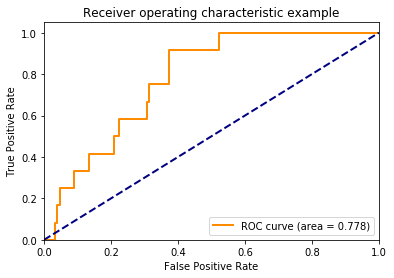

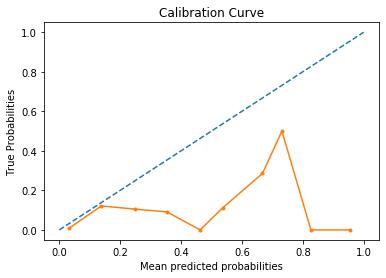

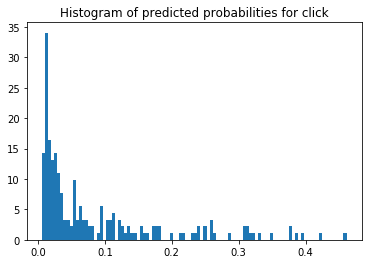

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
catboost,0.935,0.0,0.0,0.778369,-2.245024,0.461287,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


In [89]:
catboost_results = evaulate_pipeline(catboost_pipe, X_test, y_test, best_catboost_params)
catboost_df = pd.DataFrame(catboost_results, index= ['catboost'])
catboost_df

# Model 3: KNN Classifier 

In [90]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, n_jobs = 4, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [91]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_metric = float('-inf')
    worst_metric = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_hat, pos_label=1)
        curr_metric = auc(fpr, tpr)

        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best AUC metric", best_metric, ", Grid:", best_grid)
    print ("worst AUC metric", worst_metric, ", Grid:", worst_grid)
    return best_grid

### Parameters being tuned:
1. n_neighbors        = number of nearset neighbouring observation to consider for deciding on the prediciton
2. weights       = should all neighbours have equal weight or weighted by the distance to the observation


In [92]:
print (datetime.datetime.now())

# Note: previous runs showed that uniform weighting is consistently better than distanced based weighting
# hence due to slow perfromance of this classifier, we avoid the distance based weighting option
if CALC_PARAMS:
    if dev_mode:
        knn_params_grid ={'n_neighbors': [500], 
                         'weights': ['uniform']
                        }
    else:
        knn_params_grid ={'n_neighbors': [500, 1000, 150], 
                 'weights': ['uniform']
                }
    best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)
    best_knn_params
else:
    best_knn_params = get_config('knn')
print (datetime.datetime.now())


2022-01-16 22:18:14.474678
{'n_neighbors': 500, 'weights': 'uniform'}
{'n_neighbors': 1000, 'weights': 'uniform'}
{'n_neighbors': 150, 'weights': 'uniform'}
Final Result
best AUC metric 0.7383792677910326 , Grid: {'n_neighbors': 150, 'weights': 'uniform'}
worst AUC metric 0.6844919786096257 , Grid: {'n_neighbors': 500, 'weights': 'uniform'}
2022-01-16 22:18:15.531739


In [93]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=[], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=1, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=4, n_neighbors=150, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.88 , with accuracy =  0.935


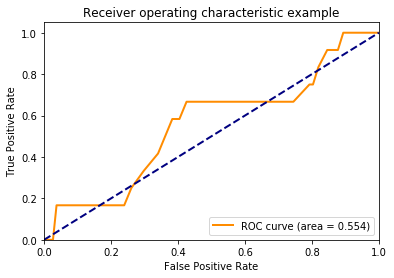

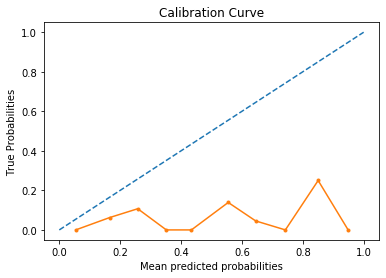

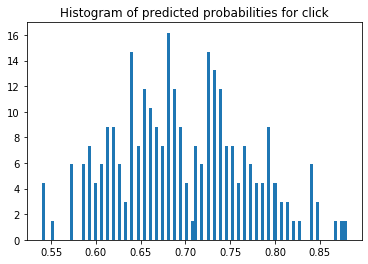

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
knn,0.935,0.0,0.0,0.5543,-2.245024,0.88,"{""n_neighbors"": 150, ""weights"": ""uniform""}"


In [94]:
knn_results = evaulate_pipeline(knn_pipeline, X_test, y_test, best_knn_params);
knn_df = pd.DataFrame(knn_results, index= ['knn'])
knn_df

# summary of model metrics

In [95]:

metrics_df = pd.concat([rf_df, knn_df,catboost_df])
metrics_df.sort_values(by='AUC')

if CALC_PARAMS:
    now = datetime.datetime.now()
    now_string = now.strftime("%m_%d_%Y__%H_%M")
    metrics_df.reset_index().to_csv(f"configuration_{now_string}_sample_{SAMPLE}.csv", index=False)
metrics_df

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.950,0.166667,1.0,0.715869,-1.726939,0.846155,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."
knn,0.935,0.000000,0.0,0.554300,-2.245024,0.880000,"{""n_neighbors"": 150, ""weights"": ""uniform""}"
catboost,0.935,0.000000,0.0,0.778369,-2.245024,0.461287,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


# Exaplinable AI:  Shap Values

In [96]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


### Overview Of Shap
- Shap Values (Shapely Additive exPlanations) is a model Agnostic method for explaining model predictions\
It is based on theory developed by Loid Shapley in the 1950's
- Shap explains a model output additivley as the sum of each variables contribution
- shap is model agnostic but has fast implementations for tree based models
- Shap is the ONLY explanation method that satisifes a set of basic properties which are natural to be required from any valid explanation method:\
1. Local accuracy: - the shap value for a given observation Xi is equal to the model prediction for Xi
2. Missingness:  A missing value has zero contribution in the explanation
3. Consistency: If the importance of a variable in model B is not smaller than in model A then its shap value for model B will not be lower than for model A


## Shap Summary Plot

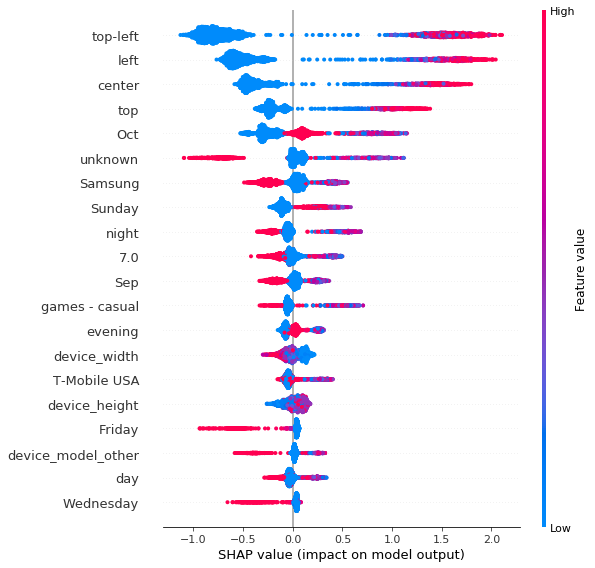

In [97]:

shap.summary_plot(shap_values)

#### explanation
This graph is actually a series of dot-plots:every observation(row) is representated as a dot
for each variable in the model we have a dot-plot showing a dot for each observation in the train set
X-axis: The shap value i.e. the negative or positive contribution of the observation's variable to the final prediction
Y-axis: in case where many observation have the same shap value the dots are stacked vertically
Color: For continuous variables the color represent whether the value of the variable is high or low in the observation

##### Example: TODO verify
in the device_diag variable we see that large screens (strong red) are associated with increased (positive) probability for a click

In [98]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

## 3 random predictions local explanations

In [99]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [100]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [101]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

# Section 8: Prediction on external data set

In [102]:
model = catboost_pipe


In [103]:
testset = pd.read_csv("ctr_dataset_test.csv")

# Apply preprocessing pipeline

In [104]:
print (datetime.datetime.now())

X_blind_test, _ = preprocessing_pipeline(testset, one_hot_encoding=USE_SMOTE, allowed_levels_dict = allowed_levels_dict)


print (datetime.datetime.now())

2022-01-16 22:18:24.336242
2022-01-16 22:18:30.470593


### Add empty dummy columns for levels that are possibly missing in the predicitons data set

In [105]:
MODEL_COLS.remove('clicked')
unknown_cols = [c for c in MODEL_COLS  if c not in X_blind_test.columns ]
for c in unknown_cols:
    print(f"adding default column for {c}")
    X_blind_test.loc[:, c] = 0

adding default column for Missing_device_model
adding default column for 7.0


In [106]:
print ([c for c in X_blind_test.columns if c not in MODEL_COLS])
X_blind_test = X_blind_test[MODEL_COLS]


['Delaware']


In [107]:
y_hat = model.predict_proba(X_blind_test)

In [108]:
best_threshold_catboost = catboost_df['threshold'].values[0]
best_threshold_catboost

0.46128721773340614

In [109]:
y_pred = (y_hat[:,1] >= best_threshold_catboost).astype(int)
predictions = pd.Series(y_pred)

#### Total predictions , total clicks predicted,  Percentage of predicted clicks:

In [110]:
f"N={predictions.count()}, Clicks={predictions.sum()}, Clicks Percent= {round(predictions.mean()*100,3)}%"

'N=629764, Clicks=4200, Clicks Percent= 0.667%'

# Group 8 output

In [111]:
predictions.to_csv('output_8.txt', index=False)

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [112]:
datetime.datetime.now()

datetime.datetime(2022, 1, 16, 22, 18, 32, 878731)